In [6]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

import torch

from sbi.analysis import pairplot

# load and read nwb files
from pynwb import NWBHDF5IO

import sys
sys.path.append('../code')

from ephys_utils import get_time_voltage_current_currindex0, syn_current
from plot_utils import adjust_spines

### Load observed data

In [13]:
M1_25degree = pickle.load(open("../code/pickles/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [15]:
prop = pd.read_csv("../data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [17]:
annotations = pd.read_csv("../data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [19]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [21]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

In [24]:
dir_locs = []
for cell_name in Xo.index:
    dir_locs.append(
        np.array(M1_25degree["M1_names"])[no_low_qual][
            np.where(Xo.index == cell_name)[0][0]
        ]
    )

#### Posteriors

In [109]:
with open("../code/save_posteriors/training_schedule_0.pickle", "rb") as f:
    npe_posterior = pickle.load(f)
with open("../code/save_posteriors/training_schedule_2d.pickle", "rb") as f:
    npep_posterior = pickle.load(f)

#### Hodgkin-Huxley-based model

In [76]:
from simulator import EphysModel

M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=40,
    noise_factor=10,
    use_pathos=True,
    chunk_size=280,
    save_chunks=True,
)

### NPE vs NPE-N

Pick example cells and demonstrate NPE vs NPE-N.

In [217]:
cell_name = '20190418_sample_8' # Pvalb Calb1_1

In [239]:
cell_name = '20181109_sample_9' # Sst Crhr2_1

In [267]:
cell_name = '20190626_sample_1' # Vip Serpinf1_1

In [295]:
cell_name = '20190327_sample_2' # L6 CT Cpa6

In [323]:
cell_name = '20190515_sample_7' # Lamp5 Egln3_1

In [357]:
cell_name = '20190418_sample_2' # Sst Th_1 # example where both npe and npe-n fail

In [359]:
prop.loc[cell_name,:]

Layer              6
Cre             SST+
RNA type    Sst Th_1
Name: 20190418_sample_2, dtype: object

In [361]:
# Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree["M1_names"])[no_low_qual][
    np.where(Xo.index == cell_name)[0][0]
]
data

'../data/raw_data/000008/sub-mouse-HZREI/sub-mouse-HZREI_ses-20190418-sample-2_slice-20190418-slice-2_cell-20190418-sample-2_icephys.nwb'

In [363]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, "r", load_namespaces=True).read()

In [364]:
xo = Xo.loc[cell_name, :].iloc[:-4].values
feature_list = range(23)

In [365]:
(
    time_obs,
    voltage_obs,
    current_obs,
    curr_index_0_obs,
) = get_time_voltage_current_currindex0(data)
liquid_junction_potential = 15.4
voltage_obs -= liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(
    area=Xo.loc[cell_name, "1-comp area"], curr_level=3e-4
)
curr_index = np.where(current_obs == 300)[0][0]
observation = {
    "data": voltage_obs[:20000, curr_index],
    "time": time_obs[:20000] * 1e3,
    "dt": 4 * 1e-5 * 1e3,
    "I": I,
}

WARNING    /Users/yvesbernaerts/Documents/PhD/hh_sbi/figures/../code/ephys_utils.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  voltage[:, curr_index_0] = df.iloc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation
 [py.warnings]
  voltage[:, curr_index_0] = df.iloc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation



In [366]:
lw=2

Text(0.5, 1.0, 'Experimental observation')

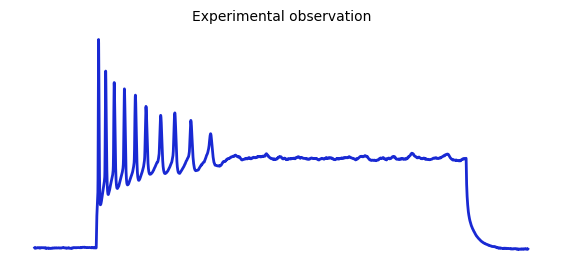

In [367]:
# Experimental observation
fig, ax = plt.subplots(1,1,figsize=(7,3))
ax.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(ax=ax, bottom=True, left=True)
ax.set_title('Experimental observation', fontsize=10)

In [368]:
#Uncomment this block to recompute

npe_samples=npe_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=xo[feature_list])))[-3:],:]
npep_samples=npep_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=xo[feature_list])))[-3:],:]
x_npe=M1_model._run_HH_model(npe_samples.numpy())
x_npep=M1_model._run_HH_model(npep_samples.numpy())

summ_stats_npe=M1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
summ_stats_npep=M1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

sims_to_show={
    'npe':{'samples':npe_samples, 'x':x_npe, 'summ_stats':summ_stats_npe},
    'npep':{'samples':npep_samples, 'x':x_npep, 'summ_stats':summ_stats_npep}
}

with open('../code/save_model_parameters/{}.pickle'.format(cell_name), 'wb') as f:
    pickle.dump(sims_to_show, f)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [369]:
with open("../code/save_model_parameters/{}.pickle".format(cell_name), "rb") as f:
    sims_to_show = pickle.load(f)

In [370]:
npe_samples = sims_to_show["npe"]["samples"]
x_npe = sims_to_show["npe"]["x"]
summ_stats_npe = sims_to_show["npe"]["summ_stats"]

npep_samples = sims_to_show["npep"]["samples"]
x_npep = sims_to_show["npep"]["x"]
summ_stats_npep = sims_to_show["npep"]["summ_stats"]

In [371]:
obs_index = np.where(Xo.index == cell_name)[0][0]

Xo_values = Xo.values[:, :-4]
Xo_mean = Xo.values[:, :-4].mean(axis=0)
Xo_std = Xo.values[:, :-4].std(axis=0)

npe_score = np.sqrt(
    ((summ_stats_npe - Xo_mean) / Xo_std - (Xo_values[obs_index, :] - Xo_mean) / Xo_std)
    ** 2
)

npep_score = np.sqrt(
    (
        (summ_stats_npep - Xo_mean) / Xo_std
        - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
    )
    ** 2
)

In [372]:
def create_figure_hor(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 5))
    else:
        fig = fig

    width, height = 0.04, 0.12
    ax_features = plt.axes([0, 0, 0.12, 1])
    ax_observation = plt.axes([.02, .01, width+.15, height+.03])
    axes_npe = np.array(
        [
            [
                plt.axes([0.15 + x, y, width, height])
                for x in [0, .06, .12, .18, .24, .3, .36]
            ]
            for y in [.86, .72, .58, .44, .3, .16, .02]
        ]
    )
    
    ax_npe_s1 = plt.axes([.13, 0.3, width+.15, height+.03])
    ax_npe_s2 = plt.axes([0.18, 0.15, width+.15, height+.03])
    ax_npe_s3 = plt.axes([0.23, 0, width+.15, height+.03])
    
    axes_npep = np.array(
        [
            [
                plt.axes([0.58 + x, y, width, height])
                for x in [0, .06, .12, .18, .24, .3, .36]
            ]
            for y in [.86, .72, .58, .44, .3, .16, .02]
        ]
    )

    ax_npep_s1 = plt.axes([.56, 0.3, width+.15, height+.03])
    ax_npep_s2 = plt.axes([0.61, 0.15, width+.15, height+.03])
    ax_npep_s3 = plt.axes([0.66, 0, width+.15, height+.03])
    
    return [ax_features, ax_observation,
            axes_npe, axes_npep,
            ax_npe_s1, ax_npe_s2,
            ax_npe_s3, ax_npep_s1,
            ax_npep_s2, ax_npep_s3]

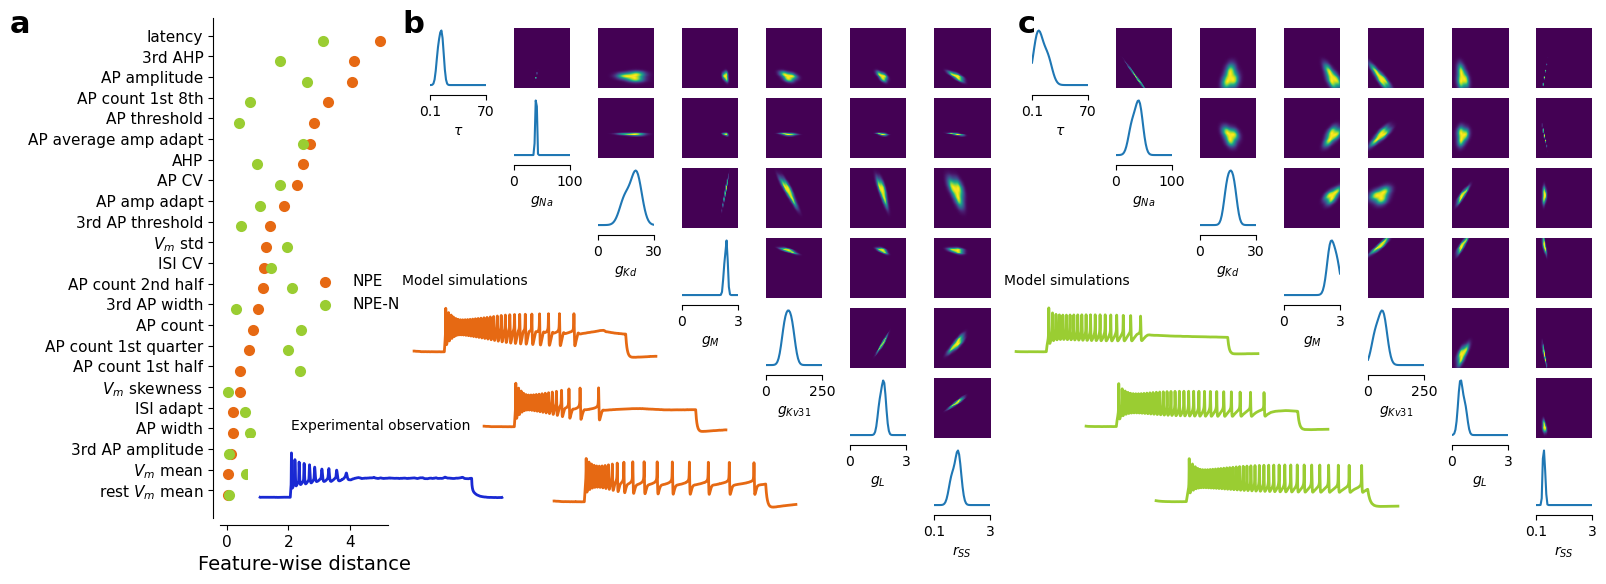

In [377]:
dims_to_show = [2, 4, 5, 6, 7, 8, 12]

fig = plt.figure(figsize=(14, 5))
ax_list = create_figure_hor(fig)

ax_features = ax_list[0]

# Feature-wise performances NPE vs NPE+
order = np.argsort(npe_score)

ax_features.scatter(
    npe_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="#e66913ff",
    label="NPE",
    lw=2,
)
ax_features.scatter(
    npep_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="yellowgreen",
    label="NPE-N",
    lw=2,
)
adjust_spines(ax_features, spines=["bottom", "left"])
ax_features.set_yticks(
    np.linspace(1, 4 * len(ephys_features) + 2, num=len(ephys_features))
)
ax_features.legend(loc=(0.5, 0.4), fontsize=11, frameon=False)
ax_features.set_xlabel("Feature-wise distance", fontsize=14)
ax_features.set_yticklabels(ephys_features[order])
ax_features.tick_params(axis="y", which="major", labelsize=11)
ax_features.tick_params(axis="x", which="major", labelsize=11)

ax_observation = ax_list[1]

# Experimental observation
ax_observation.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax_observation.set_ylim(
    [ax_observation.get_ylim()[0] - 30, ax_observation.get_ylim()[1] + 30]
)
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)
ax_observation.set_title('Experimental observation', fontsize=10)

axes_npe = ax_list[2]

# npe pairplot
pairplot(
    npe_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=list(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npe,
    upper="kde",
    diag="kde",
)

ax_npe_s1, ax_npe_s2, ax_npe_s3 = ax_list[4], ax_list[5], ax_list[6]

ax_npe_s1.plot(x_npe["time"], x_npe["data"][0, 0, :], lw=lw, color="#e66913ff")
ax_npe_s2.plot(x_npe["time"], x_npe["data"][1, 0, :], lw=lw, color="#e66913ff")
ax_npe_s3.plot(x_npe["time"], x_npe["data"][2, 0, :], lw=lw, color="#e66913ff")

axes_npep = ax_list[3]

# npe-n pairplot
pairplot(
    npep_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=list(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npep,
    upper="kde",
    diag="kde",
)

ax_npep_s1, ax_npep_s2, ax_npep_s3 = ax_list[7], ax_list[8], ax_list[9]

ax_npep_s1.plot(x_npep["time"], x_npep["data"][0, 0, :], lw=lw, color="yellowgreen")
ax_npep_s2.plot(x_npep["time"], x_npep["data"][1, 0, :], lw=lw, color="yellowgreen")
ax_npep_s3.plot(x_npep["time"], x_npep["data"][2, 0, :], lw=lw, color="yellowgreen")

for ax in [ax_npe_s1, ax_npe_s2, ax_npe_s3, ax_npep_s1, ax_npep_s2, ax_npep_s3]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])
    ax.set_xlim([ax_observation.get_xlim()[0], ax_observation.get_xlim()[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
ax_npe_s1.set_title('Model simulations', fontsize=10, loc='left')
ax_npep_s1.set_title('Model simulations', fontsize=10, loc='left')

fig.text(-0.15, .97, "a", fontsize=22, fontweight="bold")
fig.text(0.13, .97, "b", fontsize=22, fontweight="bold")
fig.text(0.57, .97, "c", fontsize=22, fontweight="bold")

plt.savefig("suppl_figs/npe_npen_{}.pdf".format(cell_name), bbox_inches="tight", pad_inches=0)